<a href="https://colab.research.google.com/github/ucfilho/SwarmCantStopNow/blob/main/Conference_2021/ABCOptmi_filter_C1_pop_500_ite_2000_RTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def buildMatriz(x):
  global Trocas, tempInicial, tempAtual 
  NPAR=1
  cols=len(tempInicial)
  size=3*cols
  x=np.array(x).reshape(1,size)
  # print('x=');print(x)
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  Tin=np.zeros((NPAR,Trocas))
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    for j in range(Trocas):
      #print('[i,j]=%d %d'%(i,j))
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 
    for jj in range(cols):
      Tin[i,jj]=tempInicial[jj]
      Tout[i,jj]=tempAtual[jj]
  return Ind_I,Ind_J,deltaT, Tin, Tout

In [3]:
def Temperatura(x):
  global Trocas, mCp,tempInicial
  
  NPAR=1
  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  erro=np.zeros((NPAR)) # valor erro se torna erro=1 quando ha algum erro e vai penalizar
  for ki in range(NPAR):
    for kj in range(Trocas):
      #Tin=np.copy(Tout)
      k=kj
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]
      
      tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
      tempSaidaF=-mCp[kj]*deltaT[ki,kj]/(mCp[j])+Tout[ki,j]
      flag=0 # flag : indica que nao entra no teste logico
      # usei flag no lugar q ifs pq a identacao ficou melhor assim
      if(Tout[ki,i] > Tout[ki,j]): #Tquente maior Tfria: vaores atuais
        if(tempSaidaQ > tempSaidaF): #Tquente maior Tfria: saidas
          flag=1
      if(flag>0):
        Tout[ki,i]=tempSaidaQ
        Tout[ki,j]=tempSaidaF
      else:
        erro[ki]=1

  return Tout,erro

In [4]:
def Area(x):

  global mCp,tempAlvo,tempInicial,Trocas,U
  
  NPAR=1
  
  Area=[]

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)

  Area_Particula=[]

  for k in range(Trocas):

    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]

    Told_i=Tatual[i]
    Told_j=Tatual[j]

    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)
    deltaT1=Tatual[i]-tempSaidaF
    deltaT2=tempSaidaQ-Tatual[j]
    try:
      A=(deltaT1-deltaT2)
      B=np.log((deltaT1/deltaT2))
      deltaTMediaLog=A/B
    except:
      deltaTMediaLog=1e99
  
    if(deltaTMediaLog==1e99):
      AreaCalc=1e99
    else:
      AreaCalc=abs(deltaT[0,k]*mCp[i]/(U*deltaTMediaLog))

    if(Told_i==Tatual[i]):
      AreaCalc=0

    if(Told_j==Tatual[j]):
      AreaCalc=0

      Area_Particula.append(AreaCalc)
      
  Area.append(Area_Particula)

  return Area

In [5]:
def Utilidades(tempAlvo,Tout,mCp):

  cols=len(mCp)
  NPAR=1

  
  '''
  caso I cita TUQin=553 e TQout=552, TUFin=303 TUFout=353
  '''
  
  TUQin=553
  TUQout=552
  TUFin=303 
  TUFout=353
  
  Areas=[]
  cargaUQtodas=[]
  cargaUFtodas=[]

  for ki in range(NPAR):
    areaTrocador=[]
    cargaUQ=0
    cargaUF=0
    for j in range(cols):
      delta=tempAlvo[j]-Tout[ki,j]
      if(delta>0):#usa UQ
        cargaUQ=cargaUQ+mCp[j]*delta
        deltaT1=(TUQin-tempAlvo[j])
        deltaT2=(TUQout-Tout[ki,j])

        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99

        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(delta)/(U*deltaTMediaLog))))

      elif(delta==0):#nao usa UF e UQ
        deltaTMediaLog=0
        areaTrocador.append(0) 

      else:#usa UF
        deltaT1=(Tout[ki,j]-TUFout)
        deltaT2=(tempAlvo[j]-TUFin)     
        cargaUF=cargaUF+mCp[j]*(-delta)

        #UF -> água resfriada -> entra a 303K e sai a 353K
        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99
        
        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(-delta)/(U*deltaTMediaLog))))

    cargaUQtodas.append(cargaUQ)
    cargaUFtodas.append(cargaUF)

    Areas.append(areaTrocador)

  return Areas, cargaUQtodas,cargaUFtodas

In [6]:
def CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
  global coefCustoUQ,coefCustoUF
  
  NPAR=1

  cost=np.zeros((NPAR))
  for i in range(NPAR):
    cargaUQ=cargaUQtodas[i]
    cargaUF=cargaUFtodas[i]
    areaTrocadores=Area[i]
    areaUtilidades=Utilidades[i]
    costTrocadores=0
    for it in areaTrocadores:
      for wii in areaUtilidades:
        if(it<1e99):
          if(wii<1e99):
            costTrocadores=costTrocadores+300*(it**0.5+wii**0.5)
          else:
            costTrocadores=1e99
            break
    costUQ=coefCustoUQ*cargaUQ
    costUF=coefCustoUF*cargaUF
    
    if(costTrocadores==1e99):
      cost[i]=1e99
    else:
      cost[i]=costUQ+costUF+costTrocadores
      
  return cost

In [7]:
def Numb(x):
  global mCp,tempAlvo,tempInicial,Trocas

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)
  Ttrocas=np.zeros((rows+4,cols))# feito em quaduplicata so para melhorar o visual
  for i in range(2):
    for j in range(cols):
      Ttrocas[i,j]=np.copy(Tatual[j])
  cont=1
  #Ttrocas.append(Tatual)
  #Ttrocas.append(Tatual) # feito em duplicata so para melhorar o visual
  for k in range(Trocas):
    cont=cont+1
    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]
    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)

    for jj in range(cols):
      Ttrocas[cont,jj]=Tatual[jj]  


  for jj in range(cols): # feito em duplicata so para melhorar o visual
    Ttrocas[cont+1,jj]=tempAlvo[jj]
    Ttrocas[cont+2,jj]=tempAlvo[jj]

  
  return Ttrocas

In [8]:
#FUN calcula o TAC para um determinado arranjo
#  cada calculo é feito em uma funcao a parte Fun usa todas funcoes 

def FUN(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  
  NPAR=1
  
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tout, Erro=Temperatura(x)
  areaTrocadores =Area(x)
  areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)
  
  # print(funr)

  return funr

In [9]:
#********************PROGRAMA PRINCIPAL*************************

Trocas=4
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453.0,393.0,523.0,533.0] #[K]
tempAtual=np.copy(tempInicial) 
#tempAtual=[453,393,523,533] #[K]
tempAlvo=[513.0,508.0,403.0,433.0] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]



In [10]:
def CalcFit(fun):
    result=0
    if(fun>=0):
      result=1/(fun+1)
    else:
      result=1+fabs(fun)
    return result

In [11]:
function = FUN

'''
def function( sol):
  #Schwefel(x):
  x=sol  
  summ=0
  for i in range(len(x)):
    new=x[i]*np.sin((abs(x[i]))**0.5)
    summ=summ+new
    top=(418.9829*len(x)-summ) 
  
  return top;
'''


'\ndef function( sol):\n  #Schwefel(x):\n  x=sol  \n  summ=0\n  for i in range(len(x)):\n    new=x[i]*np.sin((abs(x[i]))**0.5)\n    summ=summ+new\n    top=(418.9829*len(x)-summ) \n  \n  return top;\n'

In [12]:
def BestSource(GlobMin,GlobPars,Foods):
  FoodNumber=len(Foods[:,0])
  D=len(Foods[0,:])
  solution=np.zeros(D)
  for i in range(FoodNumber):
    if (f[i]<GlobMin):
      GlobMin=f[i]
      for j in range(D):
        GlobPars[j]=Foods[i,j]
  return GlobMin,GlobPars,Foods

In [13]:
def init(index,Foods,trial,f,fitness,MIN,MAX):
  D=len(Foods[0,:])
  FoodNumber=len(Foods[:,0])
  solution=np.zeros(D)
  for j in range(D):
    r=np.random.random()
    Foods[index,j]=r*(MAX[j]-MIN[j])+MIN[j]
    solution[j]=Foods[index,j]
    
  f[index]=function(solution)
  fitness[index]=CalcFit(f[index])
  trial[index]=0
  
  return Foods,trial,f,fitness

In [14]:
def initial(fitness,trial,f,Foods,GlobMin,GlobPars,MIN,MAX):
  D=len(Foods[0,:])
  FoodNumber=len(Foods[:,0])
  for i in range(FoodNumber):
    Foods,trial,f,fitness=init(i,Foods,trial,f,fitness,MIN,MAX) 
  GlobMin=f[0]
  for i in range(D):
    GlobPars[i]=Foods[0,i]
  return  f,Foods,GlobMin,GlobPars


In [15]:
def EmployedBees(trial,Foods,MIN,MAX):
  FoodNumber=len(Foods[:,0])
  NP=FoodNumber
  D=len(Foods[0,:])
  solution=np.zeros(D)
  for i in range(FoodNumber):
    r = np.random.random()
    par2chan= int(r*D)
    r = np.random.random()
    neighbour=int(r*D)
    if(neighbour >= NP):
      neighbour=NP-1
      
    while(neighbour==i):
      r = np.random.random()
      neighbour=int(r*FoodNumber)
      if(neighbour >= NP):
        neighbour=NP-1
    for j in range(D):
      solution[j]=Foods[i,j]

    r = np.random.random()
    A=Foods[i,par2chan]
    B=Foods[neighbour,par2chan]
    solution[par2chan]=Foods[i,par2chan]+(A-B)*(r-0.5)*2;
    if (solution[par2chan]<MIN[par2chan]):
      solution[par2chan]=MIN[par2chan]
    if (solution[par2chan]>MAX[par2chan]):
      solution[par2chan]=MAX[par2chan]
    ObjValSol=function(solution)
    FitnessSol=CalcFit(ObjValSol)
    
    if(FitnessSol>fitness[i]):
      trial[i]=0
      for j in range(D):
        Foods[i,j]=solution[j]
      f[i]=ObjValSol
      fitness[i]=FitnessSol
    else:
      trial[i]=trial[i]+1 
      
  return trial,Foods

In [16]:
def CalcProb(fitness,prob):
  FoodNumber=len(fitness)
  maxfit=fitness[0]
  for i in range(1,FoodNumber):    
    if (fitness[i]>maxfit):
      maxfit=fitness[i]
  for i in range(FoodNumber):
    prob[i]=(0.9*(fitness[i]/maxfit))+0.1
  return fitness,prob


In [17]:
def OnlookerBees(trial,Foods,MIN,MAX):
  D=len(Foods[0,:])
  solution=np.zeros(D)
  FoodNumber=len(Foods[:,0])
  i=0
  t=0
  while(t<FoodNumber):
    r = np.random.random()
    if(r<prob[i]): 
      r = np.random.random()
      t=t+1
      par2chan=int(r*D)
      r = np.random.random()
      neighbour=int(r*FoodNumber)

      while(neighbour==i):
        r = np.random.random()
        neighbour=int(r*FoodNumber)
      for j in range(D):
        solution[j]=Foods[i,j]

      r = np.random.random()
      A=Foods[i,par2chan]
      B=Foods[neighbour,par2chan]
      solution[par2chan]=A+(A-B)*(r-0.5)*2

      if (solution[par2chan]<MIN[par2chan]):
              solution[par2chan]=MIN[par2chan]
      if (solution[par2chan]>MAX[par2chan]):
              solution[par2chan]=MAX[par2chan]
      ObjValSol=function(solution)
      FitnessSol=CalcFit(ObjValSol)
              
      if(FitnessSol>fitness[i]):
        trial[i]=0
        for j in range(D):
          Foods[i,j]=solution[j]
        f[i]=ObjValSol
        fitness[i]=FitnessSol
      else:
        trial[i]=trial[i]+1
      i=i+1
      if (i==FoodNumber):
        i=0
  return trial,Foods


In [18]:
def ScoutBees(fitness,f,Foods,trial,MIN,MAX):
  FoodNumber=len(Foods[:,0])
  max_trial=0
  for i in range(1,FoodNumber):
    if (trial[i]>trial[max_trial]):
      max_trial=i
  if(trial[max_trial]>=limit):
    Foods,trial,f,fitness=init(max_trial,Foods,trial,f,fitness,MIN,MAX)
  return trial,Foods


In [19]:
'''/*Main program of the ABC algorithm*/'''

NPAR=500 #Numero de fontes de comida
ITE=2000 #ITERACOES (maxCycle)

MAX= [3,3,3,3,1,1,1,1,0,0,0,0] 
MIN= [2,2,2,2,0,0,0,0,-100,-100,-100,-100]
PAR=len(MAX) #NUM DE PARAMETROS A SER OTIMIZADOS
limit=100 # quantas vezes obtem resposta identica antes de encerrar 
runtime=3 # quantas vezes vai rodar para tirar a media


In [20]:

f=np.zeros(NPAR) 
Foods=np.zeros((NPAR,PAR)) 
solution=np.zeros(PAR)
fitness=np.zeros(NPAR)
trial=np.zeros(NPAR)
prob=np.zeros(NPAR)
GlobPars=np.zeros(PAR)
GlobMins=np.zeros(runtime)
GlobMin=1e99


In [21]:
# rule half-half
N_2 = int(NPAR/3)

In [22]:
f1=f[:N_2];f2 = f[N_2:];
Foods1=Foods[:N_2,:];Foods2=Foods[N_2:,:];
solution1= np.zeros(PAR);solution2= np.zeros(PAR)
fitness1=fitness[:N_2];fitness2=fitness[N_2:];
trial1=trial[:N_2];trial2=trial[N_2:]
prob1=prob[:N_2];prob2=prob[N_2:];
GlobPars1=np.zeros(PAR);GlobPars2=np.zeros(PAR);
GlobMins1=np.zeros(runtime);GlobMins2=np.zeros(runtime);
GlobMin1=1e99;GlobMin2=1e99

In [23]:
initial_time = time.time()

for run in range(runtime):
  f1,Foods1,GlobMin1,GlobPars1= initial(fitness1,trial1,f1,Foods1,GlobMin1,GlobPars1,MIN,MAX)
  GlobMin1,GlobPars1,Foods1=BestSource(GlobMin1,GlobPars1,Foods1)

  f2,Foods2,GlobMin2,GlobPars2= initial(fitness2,trial2,f2,Foods2,GlobMin2,GlobPars2,MIN,MAX)
  GlobMin2,GlobPars2,Foods2=BestSource(GlobMin2,GlobPars2,Foods2)

  for iter in range(ITE):
    trial1,Foods1=EmployedBees(trial1,Foods1,MIN,MAX);
    trial2,Foods2=EmployedBees(trial2,Foods2,MIN,MAX)

    fitness1,prob1=CalcProb(fitness1,prob1);
    fitness2,prob2=CalcProb(fitness2,prob2)

    trial1,Foods1=OnlookerBees(trial1,Foods1,MIN,MAX);
    trial2,Foods2=OnlookerBees(trial2,Foods2,MIN,MAX)

    GlobPars2_rec = GlobPars2.copy()
    GlobPars1_rec = GlobPars1.copy()

    GlobMin1,GlobPars1,Foods1=BestSource(GlobMin1,GlobPars1,Foods1);
    GlobMin2,GlobPars2,Foods2=BestSource(GlobMin2,GlobPars2,Foods2)

    trial1,Foods1=ScoutBees(fitness1,f1,Foods1,trial1,MIN,MAX)
    trial2,Foods2=ScoutBees(fitness2,f2,Foods2,trial2,MIN,MAX)

    GlobPars2_rec = GlobPars2.copy()
    GlobPars1_rec = GlobPars1.copy()
    
    Foods1[0,:] = GlobPars2.copy()
    Foods1[1,:] = GlobPars1.copy()

    Foods1[2,:] = (GlobPars1+GlobPars1_rec*2.0)/3
    

    Foods2[0,:] = GlobPars2.copy()
    Foods2[1,:] = GlobPars1.copy()
    Foods2[2,:] = (GlobPars2+GlobPars2_rec*2.0)/3


    if(GlobMin1 > GlobMin2):
      GlobMin1 = GlobMin2
    else:
      GlobMin2 = GlobMin1


  '''
  for j in range(PAR):
    print("GlobalParam[",j+1,"]:", GlobPars1[j])

  '''
  current_time = time.time() -initial_time   
  print("run",run+1,"time =",current_time ,"GBest=",GlobMin2," \n");
  GlobMins2[run]=GlobMin2

mean=np.average(GlobMins2)
sd_mean = np.std(GlobMins2)
best_ans = GlobMins2.min()

print("Means of",runtime,"runs:",mean,"\n")
print("Best ans of",runtime,"runs:",best_ans,"\n")
print("Deviation of",runtime,"runs:",sd_mean,"\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


run 1 time = 486.2266676425934 GBest= 14879.769629836373  

run 2 time = 970.4770765304565 GBest= 13037.966062250254  

run 3 time = 1452.4731945991516 GBest= 13196.457979289109  

Means of 3 runs: 13704.731223791912 

Best ans of 3 runs: 13037.966062250254 

Deviation of 3 runs: 833.3932099960554 



In [24]:
BEST = GlobPars2
Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(BEST)
print(Ind_I)
print(Ind_J)
print(deltaT)

[[3 2 3 2]]
[[0 0 1 1]]
[[-39.99667996 -19.0333546  -54.5938608  -28.00848008]]


In [25]:
Busca=Numb(BEST)
print(pd.DataFrame(Busca))
df=pd.DataFrame(Busca)

            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  482.997510  393.000000  523.000000  493.003320
3  490.135018  393.000000  503.966645  493.003320
4  490.135018  474.890791  503.966645  438.409459
5  490.135018  495.897151  475.958165  438.409459
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


Text(0, 0.5, 'Temperature (K)')

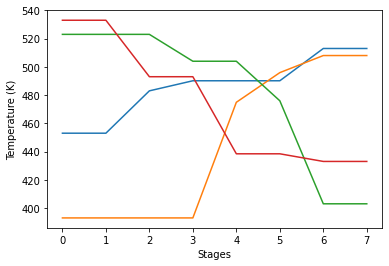

In [26]:
Streams=4
Change=range(Streams+4) # Streams+4 so para ficar com um visual melhor
for k in range(Streams):
  plt.plot(Change,df.iloc[:,k])
plt.xlabel('Stages')
plt.ylabel('Temperature (K)')